# Figure 4 #

In this notebook we show how to perform the cluster analysis shown in figure 4. We first read pickle files generated in 00_calculate 


In [2]:
import pickle
import numpy as np

# calculate eRMSD from native
fname = "ermsd.p"
print "# reading pickle %s" % fname,
ermsd = pickle.load(open(fname, "r"))
print " - ", ermsd.shape

# calculate RMSD from native
fname = "rmsd.p"
print "# reading pickle %s" % fname,
rmsd = pickle.load(open(fname, "r"))
print " - ", rmsd.shape

# Calculate G-vectors
fname = "gvec.p"
print "# reading pickle %s" % fname,
gvec,seq = pickle.load(open(fname, "r"))
print " - shape", gvec.shape

# remove samples with ermsd larger than 1.5 and reshape. 
# the flattened array is later fed to the clustering routine
n = gvec.shape[0]
qq = np.where(ermsd<1.5)[0]
gvecs = gvec.reshape(n,-1)[qq]
print "# Gvec, new shape ", gvecs.shape



# reading pickle ermsd.p  -  (20000,)
# reading pickle rmsd.p  -  (20000,)
# reading pickle gvec.p  - shape (20000, 14, 14, 4)
20000
# Gvec, new shape  (13958, 784)


Now we call DBSCAN function from sklearn, giving as input the list of g-vectors. The parameters eps and min_samples are be system/simulation dependent. As a rough rule-of-thumb, reasonable results are obtained by setting eps  in the range 0.2-0.6. A pragmatic choice is to tune eps/min sample so as to obtain ~ 10 clusters with a intra-centroid (IC) eRMSD distance below 0.9. 

In [7]:
import barnaba.cluster as cc

# calculate clusters. Call the function dbscan and return list of labels and center indeces
new_labels, center_idx = cc.dbscan(gvecs,list(qq),eps=0.45,min_samples=70)

# write to pickle for later
pickle.dump([new_labels,center_idx],open("cluster.p", "w"))

    

# eps:1.684 min_samples:70  nclusters: 10
#  silhouette score: 0.1315
# Avg silhouette: 0.3627 
# assigned samples :8444 total samples:13958 
#  N size       max eRMSD (IC)       med eRMSD (IC) max eRMSD (centroid) med eRMSD (centroid) center 
# 00 3326                0.864                0.468                0.615                0.384 01 16744
# 01 1056                0.997                0.654                0.764                0.583 02 6453
# 02 0994                0.884                0.467                0.617                0.383 05 10605
# 03 0693                0.898                0.522                0.666                0.434 08 5335
# 04 0614                0.813                0.477                0.572                0.387 07 14232
# 05 0597                0.945                0.550                0.733                0.460 06 6223
# 06 0535                0.963                0.604                0.711                0.519 00 8389
# 07 0334                0.828         

One possible way to visualize the cluster is to perform a principal component analysis and make a scatter plot.

# Cumulative explained variance of component: 1= 21.6 2:= 33.3 3= 40.0


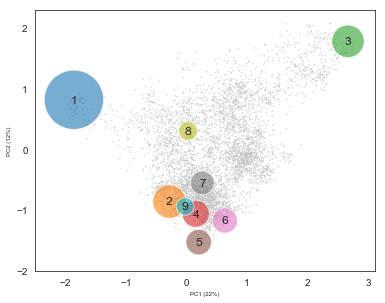

In [12]:
# Do plots. Import matplotlib and seaborn 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
import matplotlib as mpl
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

# calculate PCA
v,w = cc.pca(gvecs,nevecs=3)
# Define figure and set aspect
fig, ax = plt.subplots(figsize=(6.3,4.8))
ax.set_aspect(1)

# calculate explained variance for the first two components
plt.xlabel(r'PC1 (%2.0f%s)' % (v[0]*100,"%"),fontsize=12)
plt.ylabel(r'PC2 (%2.0f%s)' % (v[1]*100-v[0]*100,"%"),fontsize=12)
print("# Cumulative explained variance of component: 1=%5.1f 2:=%5.1f 3=%5.1f" % (v[0]*100,v[1]*100,v[2]*100))

# define colors fxor clusters. Noise is gray point
cp = sns.color_palette("hls",n_colors=len(center_idx),desat=0.8)
colors = [cp[j-1] if(j!=0) else (0.77,0.77,0.77) for j in new_labels]
size = [0.12 if(j==0) else 0.0 for j in new_labels]
# scatterplot the noise
plt.scatter(w[:,0],w[:,1],s=size,c=colors,zorder=0)

# make circles in the center of the cluster
patches = []
new_labels = np.array(new_labels)
for i,k in enumerate(center_idx):
    plt.text(w[k,0],w[k,1],str(i+1),ha='center',va='center',fontsize=12)
    rr = np.sqrt(1.*len(np.where(new_labels==i+1)[0])/len(new_labels))
    circle = mpatches.Circle((w[k,0],w[k,1]), rr, ec='k')
    patches.append(circle)
p = PatchCollection(patches, cmap=mpl.cm.tab10, alpha=0.6)
p.set_array(np.arange(len(center_idx))+1)
ax.add_collection(p)

# set nice limits
ax.xaxis.label.set_size(6)
ax.yaxis.label.set_size(6)
ax.set_xlim([-2.5,3.1])
ax.set_ylim([-2.,2.3])
ax.set_xticks([-2,-1,0,1,2,3])
ax.set_yticks([-2,-1,0,1,2])
#plt.savefig("clusters.png",dpi=600)
#plt.close()
plt.show()

As a last step, we analyze all the cluster individually. We save centroids to a PDB and cluster members to an xtc trajectory file. For each cluster, we calculate the ermsd and rmsd between centroid and cluster memebers. 


In [14]:
import mdtraj as md
import barnaba as bb
print("# Write centroids to PDB files and cluster members to .xtc")
top = "topology.pdb"
traj = "trajectory.dcd" 
t = md.load(traj, top=top)
dd1 = []
dd2 = []
ll = []
for i,k in enumerate(center_idx):
    t[qq[k]].save_pdb("cluster_%03d.test.pdb" % (i))
    idxs = [ii for ii,kk in enumerate(new_labels) if(kk==i+1)]
    t[qq[idxs]].save_xtc("cluster_%03d.traj.xtc" % (i))
    ll.append(100.*len(idxs)/(n))
    ermsd_t = bb.ermsd("cluster_%03d.test.pdb" % (i),"cluster_%03d.traj.xtc" % (i),topology=top)
    rmsd_t = bb.rmsd("cluster_%03d.test.pdb" % (i),"cluster_%03d.traj.xtc" % (i),topology=top)
    dd1.append(ermsd_t)
    dd2.append(rmsd_t)
    

# Write centroids to PDB files and cluster members to .xtc


# Loaded reference cluster_000.test.pdb 
# Loaded target cluster_000.traj.xtc 


# found  165 atoms in common


# Loaded reference cluster_001.test.pdb 
# Loaded target cluster_001.traj.xtc 


# found  165 atoms in common


# Loaded reference cluster_002.test.pdb 
# Loaded target cluster_002.traj.xtc 


# found  165 atoms in common


# Loaded reference cluster_003.test.pdb 
# Loaded target cluster_003.traj.xtc 


# found  165 atoms in common


# Loaded reference cluster_004.test.pdb 
# Loaded target cluster_004.traj.xtc 


# found  165 atoms in common


# Loaded reference cluster_005.test.pdb 
# Loaded target cluster_005.traj.xtc 


# found  165 atoms in common


# Loaded reference cluster_006.test.pdb 
# Loaded target cluster_006.traj.xtc 


# found  165 atoms in common


# Loaded reference cluster_007.test.pdb 
# Loaded target cluster_007.traj.xtc 


# found  165 atoms in common
# found  165 atoms in common


# Loaded reference cluster_008.test.pdb 
# Loaded target cluster_008.traj.xtc 


And now we box-plot the data. 

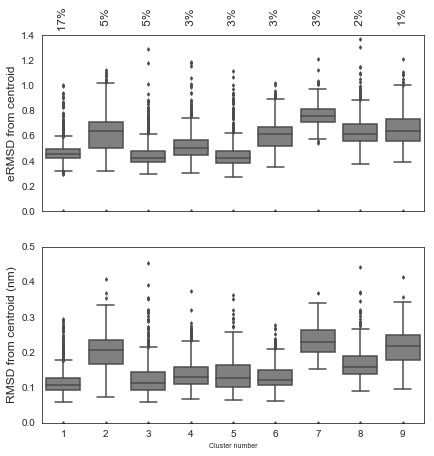

In [25]:

# define figure
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(6.2,6.3))
# do the boxplot
ax1 = sns.boxplot(data=dd1,color='0.5',ax=ax1,fliersize=2.5)
ax2 = sns.boxplot(data=dd2,color='0.5',ax=ax2,fliersize=2.5)

# write percentages
for j in range(9):
    ax1.text(j,1.5,"%4.0f%s" % (ll[j],"%"),ha="center",va="center",rotation=90,fontsize=12)
# set limits and labels
ax1.set_ylim(0,1.4)
ax1.set_ylabel("eRMSD from centroid",fontsize="12")
ax2.set_ylim(0,0.5)
ax2.set_ylabel("RMSD from centroid (nm)",fontsize="12")
ax2.set_xlabel("Cluster number",fontsize="7")
ax2.set_xticklabels(["1","2","3","4","5","6","7","8","9"])
plt.subplots_adjust(right=0.98, top=0.98)
#plt.savefig("cluster_stats.png",dpi=600)
#plt.close()
plt.show()


Finally, we produce the dynamic secondary structures. We start from native

In [5]:
import os
native = "2KOC"
cmd1 = "barnaba ANNOTATE --trj %s.pdb --top %s.pdb -o %s" % (native,native,native) 
cmd2 = "barnaba SEC_STRUCTURE --ann %s.ANNOTATE.stacking.out %s.ANNOTATE.pairing.out -o %s" % (native,native,native) 
os.system(cmd1)
os.system(cmd2)


0

Native 
<img src="2KOC.SEC_STRUCTURE_175steps.svg" width=300 height=300>

And we do the same for the first three clusters:

In [14]:
top = "topology.pdb"
for i in range(3): 
    cmd1 = "barnaba ANNOTATE --trj cluster_00%d.traj.xtc --top %s -o c%d" % (i,top,i) 
    cmd2 = "barnaba SEC_STRUCTURE \
        --ann c%d.ANNOTATE.stacking.out c%d.ANNOTATE.pairing.out -o c%d" % (i,i,i)
    os.system(cmd1)
    os.system(cmd2)
    print cmd1

barnaba ANNOTATE --trj cluster_000.traj.xtc --top topology.pdb -o c0
barnaba ANNOTATE --trj cluster_001.traj.xtc --top topology.pdb -o c1
barnaba ANNOTATE --trj cluster_002.traj.xtc --top topology.pdb -o c2


In [16]:
%ls *.svg


2KOC.SEC_STRUCTURE_175steps.svg  c1.SEC_STRUCTURE_234steps.svg
c0.SEC_STRUCTURE_166steps.svg    c2.SEC_STRUCTURE_232steps.svg


## Cluster 1 ##
<img src="c0.SEC_STRUCTURE_166steps.svg" width=300 height=300>

## Cluster 2 ##
<img src="c1.SEC_STRUCTURE_234steps.svg" width=300 height=300>

## Cluster 3 ##
<img src="c2.SEC_STRUCTURE_232steps.svg" width=300 height=300>